<a href="https://colab.research.google.com/github/wangechi01-a/Financial-Inclusion-in-Africa/blob/main/Financial_Inclusion_in_Africa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'financial-inclusion:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5267402%2F8766155%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240627%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240627T130220Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D00f240f81bc2f5183a00731ec611edeab8cf1d5a8fe3b90a414f942d7408851dca552b9e4fa7f81c3247e73a6dcf2107d3c4be0e8b821a0c321dc9a552e4ddf684ef6697b1d79a8814e89979ca2f5884f28cb41220036a35f22aa9e9d75dd94bf5820be231e565fe44d7023d9e5954bd319d9f8f7e02b367458ca3b6d2a5cbb5c8d7c9dffee0f35f770df96daaabe877ef39aee9d21657506c8288ec2f50e8919ca64f4bc0d3d7a7a6a63e6b3b158c44aa2c531cbd0ca5ed4d3b91072dbf4466226d19bd2e5af773de8728c4678eb984210c0d23303dc6782cf672f548e392702100887879e7570868d0c4d46ba5329ba36a98ed5ead56b58d81043be7b99545'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 430530 bytes downloaded
Downloaded and uncompressed: financial-inclusion
Data source import complete.


In [2]:
!pip install catboost

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from scipy.stats import boxcox,zscore
from scipy.stats import pearsonr

from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

## Loading the Dataset

In [5]:
train = pd.read_csv("/kaggle/input/financial-inclusion/Train.csv")
test = pd.read_csv("/kaggle/input/financial-inclusion/Test.csv")
var_df = pd.read_csv("/kaggle/input/financial-inclusion/VariableDefinitions.csv")
ss = pd.read_csv("/kaggle/input/financial-inclusion/SampleSubmission.csv")

In [6]:
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [7]:
test.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


In [8]:
var_df

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,The interviewee’s relationship with the head o...
9,marital_status,The martial status of the interviewee: Married...


In [9]:
ss.head()# Sample Submission File

,unique_id,bank_account
0,uniqueid_1 x Kenya,0
1,uniqueid_2 x Kenya,0
2,uniqueid_3 x Kenya,0
3,uniqueid_4 x Kenya,0
4,uniqueid_5 x Kenya,0


In [10]:
# Checking the shape of the datasets
train.shape,test.shape

((23524, 13), (10086, 12))

In [11]:
#Show some information about the train dataset: null_values,dtype
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


- The output shows the list of variables, sizes, if it contains missing values and data type for each variable. From the dataset, we don’t have any missing values and we have 3 features of integer data type and 10 features of the object data type.

In [12]:
#Checking some information about the test dataset; null_values, dtpyes
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10086 entries, 0 to 10085
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 10086 non-null  object
 1   year                    10086 non-null  int64 
 2   uniqueid                10086 non-null  object
 3   location_type           10086 non-null  object
 4   cellphone_access        10086 non-null  object
 5   household_size          10086 non-null  int64 
 6   age_of_respondent       10086 non-null  int64 
 7   gender_of_respondent    10086 non-null  object
 8   relationship_with_head  10086 non-null  object
 9   marital_status          10086 non-null  object
 10  education_level         10086 non-null  object
 11  job_type                10086 non-null  object
dtypes: int64(3), object(9)
memory usage: 945.7+ KB


- The output shows the list of variables, sizes, if it contains missing values and data type for each variable. From the dataset, we don’t have any missing values and we have 3 features of integer data type and 9 features of the object data type.

In [13]:
#Checking for missing values
train.isnull().sum()

country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

- There are no missing values in the train dataset

In [14]:
#Checking for missing values in the Test Dataset
test.isnull().sum()

country                   0
year                      0
uniqueid                  0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

- There are no missing values in the test dataset

In [15]:
# Check for any duplicated rows in the train dataset
print('Duplicates in train:',train.duplicated().sum())
print('Duplicates in test:',test.duplicated().sum())

Duplicates in train: 0
Duplicates in test: 0


In [16]:
#Displaying Numerical columns
num_cols = train.select_dtypes(include = "number").columns
num_cols

Index(['year', 'household_size', 'age_of_respondent'], dtype='object')

In [17]:
#Displaying Categorical columns
cat_cols = train.select_dtypes(include = "object").columns
cat_cols

Index(['country', 'uniqueid', 'bank_account', 'location_type',
       'cellphone_access', 'gender_of_respondent', 'relationship_with_head',
       'marital_status', 'education_level', 'job_type'],
      dtype='object')

In [18]:
#Checking for Descriptive statistics on numerical variables
train.describe().T

,count,mean,std,min,25%,50%,75%,max
year,23524.0,2016.975939,0.847371,2016.0,2016.0,2017.0,2018.0,2018.0
household_size,23524.0,3.797483,2.227613,1.0,2.0,3.0,5.0,21.0
age_of_respondent,23524.0,38.805220,16.520569,16.0,26.0,35.0,49.0,100.0


In [19]:
#Checking for the descriptive statistics on categorical variables
train.describe(include ="object").T

,count,unique,top,freq
country,23524,4,Rwanda,8735
uniqueid,23524,8735,uniqueid_1,4
bank_account,23524,2,No,20212
location_type,23524,2,Rural,14343
cellphone_access,23524,2,Yes,17454
gender_of_respondent,23524,2,Female,13877
relationship_with_head,23524,6,Head of Household,12831
marital_status,23524,5,Married/Living together,10749
education_level,23524,6,Primary education,12791
job_type,23524,10,Self employed,6437


In [20]:
# Mean age of people that have bank account
train.groupby('bank_account')['age_of_respondent'].mean()

bank_account
No     38.675292
Yes    39.598128
Name: age_of_respondent, dtype: float64

- Checking the number of unique values  

In [21]:
# check unique values in dataset
train.apply(lambda x: len(x.unique()))

country                      4
year                         3
uniqueid                  8735
bank_account                 2
location_type                2
cellphone_access             2
household_size              20
age_of_respondent           85
gender_of_respondent         2
relationship_with_head       6
marital_status               5
education_level              6
job_type                    10
dtype: int64

# Visualization

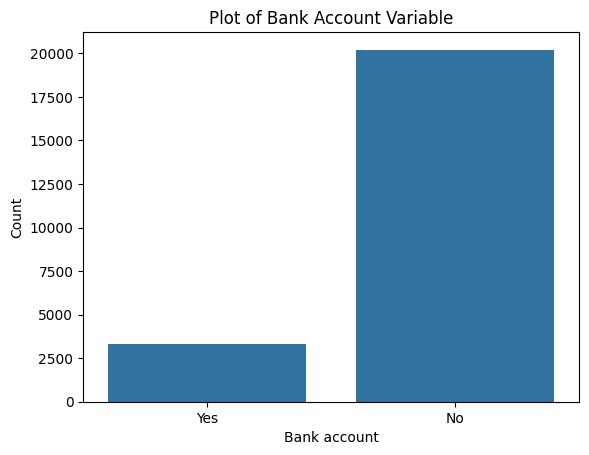

In [22]:
# Explore Target distribution
sns.countplot(x='bank_account', data=train)
plt.title('Plot of Bank Account Variable')
plt.xlabel('Bank account')
plt.ylabel('Count')
plt.show()


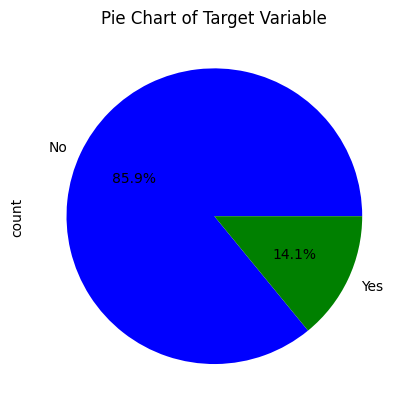

In [23]:
train['bank_account'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['blue', 'green'])
plt.title('Pie Chart of Target Variable')
plt.show()


# The pie chart above shows that 85.9% of the interviewees are likely to not have bank accounts while 14.1% of the interviewees could have bank accounts

country
Rwanda      8735
Tanzania    6620
Kenya       6068
Uganda      2101
Name: count, dtype: int64


<Figure size 1100x500 with 0 Axes>

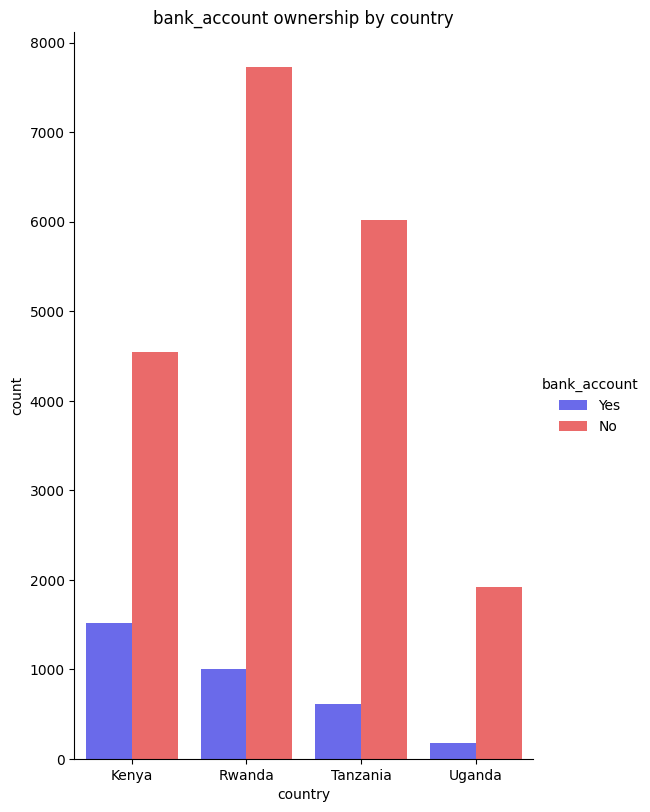

In [24]:

print(train['country'].value_counts())
plt.figure(figsize=(11,5))
sns.catplot(x='country', hue='bank_account', data=train, kind='count', height=8, aspect=0.7, palette= 'seismic')
plt.title('bank_account ownership by country')
plt.xlabel('country')
plt.ylabel('count')
plt.show()

- This shows the number of interviewees in different countries; country
  - Rwanda      8735
  - Tanzania    6620
  - Kenya       6068
  - Uganda      2101
 - With Rwanda having the highest number of interviewees and Uganda the least number

location_type
Rural    14343
Urban     9181
Name: count, dtype: int64


<Figure size 1000x500 with 0 Axes>

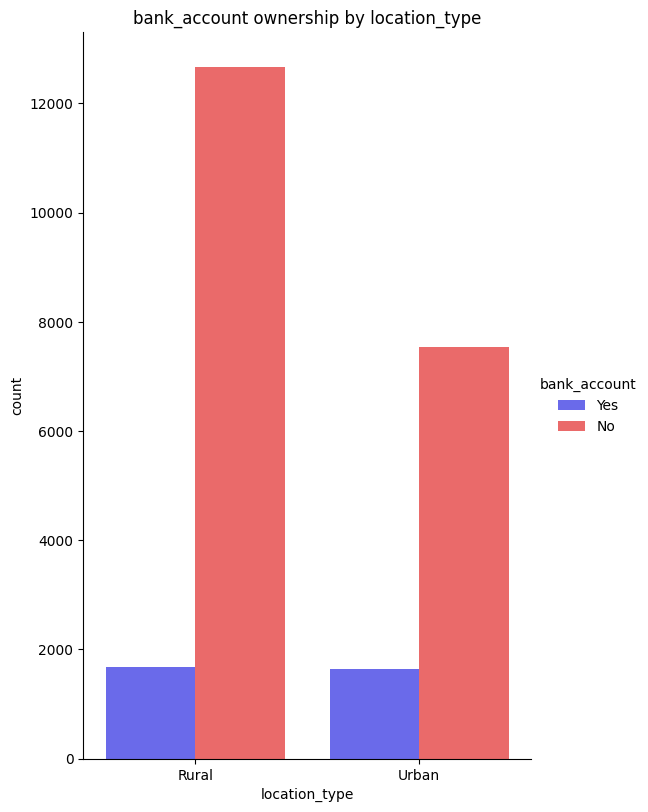

In [25]:
print(train['location_type'].value_counts())
plt.figure(figsize=(10,5))
sns.catplot(x='location_type', hue='bank_account', data=train, kind='count', height=8, aspect=0.7, palette= 'seismic')
plt.title('bank_account ownership by location_type')
plt.xlabel('location_type')
plt.ylabel('count')
plt.show()

# The above plot shows how location type affect bank account adaption

cellphone_access
Yes    17454
No      6070
Name: count, dtype: int64


<Figure size 1000x500 with 0 Axes>

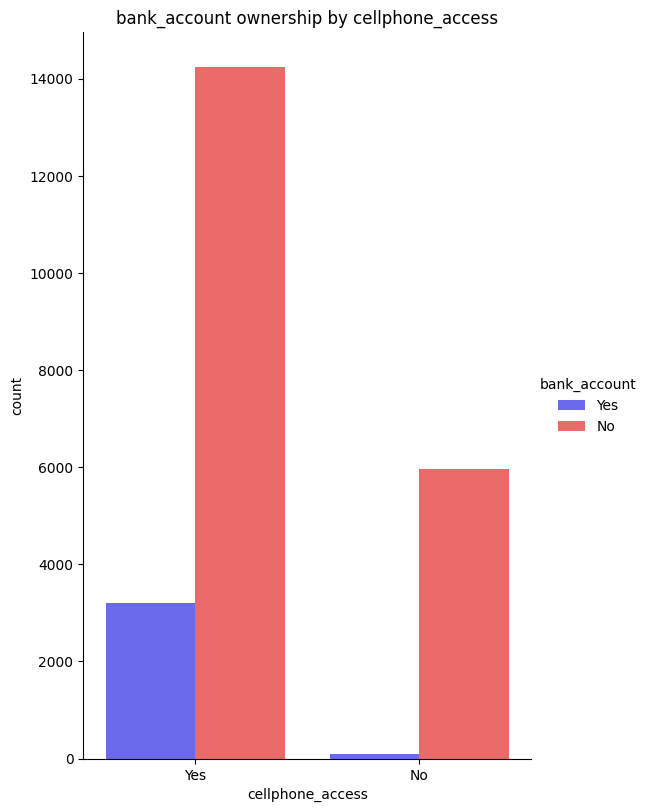

In [26]:
print(train['cellphone_access'].value_counts())
plt.figure(figsize=(10,5))
sns.catplot(x='cellphone_access', hue='bank_account', data=train, kind='count', height=8, aspect=0.7, palette= 'seismic')
plt.title('bank_account ownership by cellphone_access')
plt.xlabel('cellphone_access')
plt.ylabel('count')
plt.show()

# The above plot shows how cellphone_access affect bank account adaption

gender_of_respondent
Female    13877
Male       9647
Name: count, dtype: int64


<Figure size 1000x500 with 0 Axes>

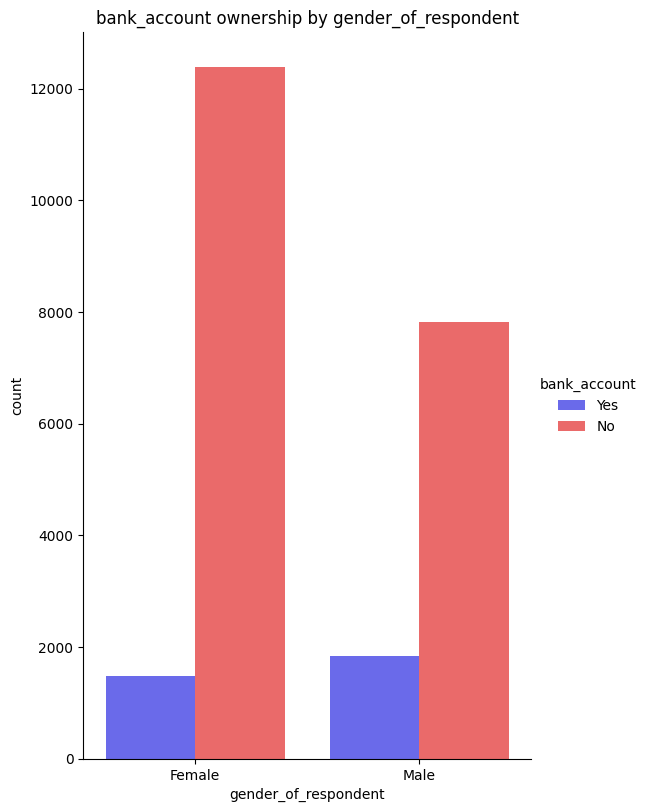

In [27]:
print(train['gender_of_respondent'].value_counts())
plt.figure(figsize=(10,5))
sns.catplot(x='gender_of_respondent', hue='bank_account', data=train, kind='count', height=8, aspect=0.7, palette= 'seismic')
plt.title('bank_account ownership by gender_of_respondent')
plt.xlabel('gender_of_respondent')
plt.ylabel('count')
plt.show()

# This plot shows how gender respondents(Female,Males) affect bank account adaption

relationship_with_head
Head of Household      12831
Spouse                  6520
Child                   2229
Parent                  1086
Other relative           668
Other non-relatives      190
Name: count, dtype: int64


<Figure size 1000x500 with 0 Axes>

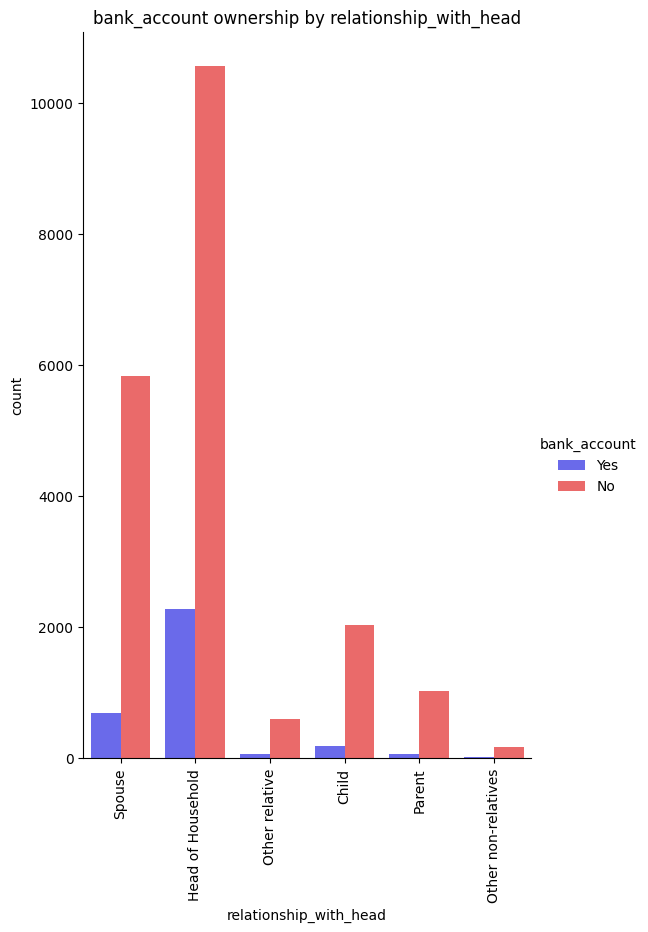

In [28]:
print(train['relationship_with_head'].value_counts())
plt.figure(figsize=(10,5))
sns.catplot(x='relationship_with_head', hue='bank_account', data=train, kind='count', height=8, aspect=0.7, palette= 'seismic')
plt.title('bank_account ownership by relationship_with_head')
plt.xlabel('relationship_with_head')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.show()

# The above plot shows how relationship with head affect bank account adaption

marital_status
Married/Living together    10749
Single/Never Married        7983
Widowed                     2708
Divorced/Seperated          2076
Dont know                      8
Name: count, dtype: int64


<Figure size 1000x500 with 0 Axes>

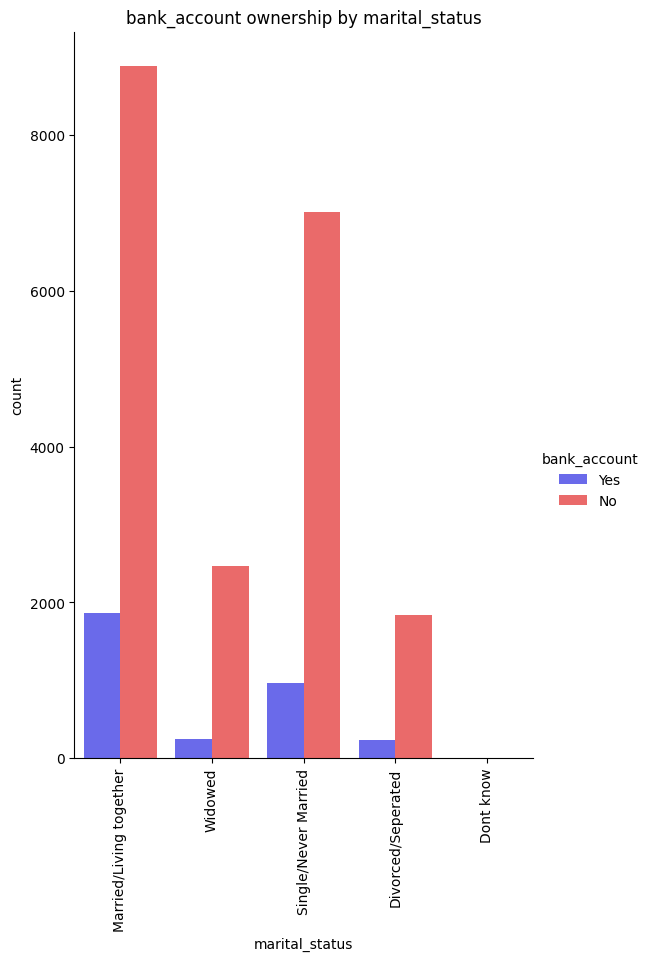

In [29]:
print(train['marital_status'].value_counts())
plt.figure(figsize=(10,5))
sns.catplot(x='marital_status', hue='bank_account', data=train, kind='count', height=8, aspect=0.7, palette= 'seismic')
plt.title('bank_account ownership by marital_status')
plt.xlabel('marital_status')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.show()

# The above plot shows how marital status affect bank adaption

education_level
Primary education                  12791
No formal education                 4515
Secondary education                 4223
Tertiary education                  1157
Vocational/Specialised training      803
Other/Dont know/RTA                   35
Name: count, dtype: int64


<Figure size 1000x500 with 0 Axes>

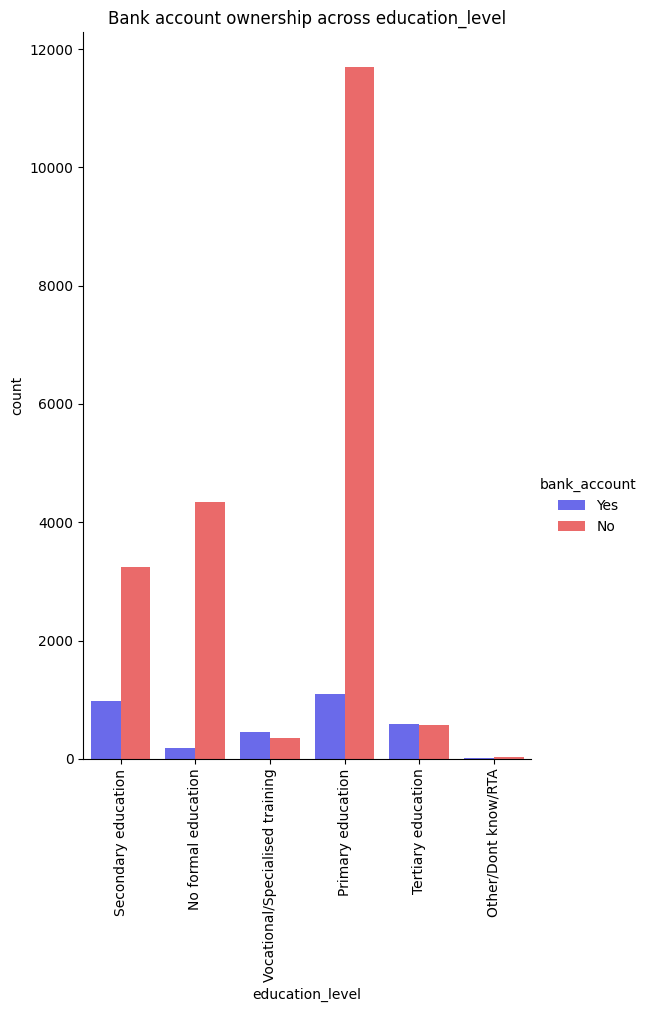

In [30]:
print(train['education_level'].value_counts())
plt.figure(figsize=(10,5))
sns.catplot(x='education_level', hue='bank_account', data=train, kind='count', height=8, aspect=0.7, palette= 'seismic')
plt.title('Bank account ownership across education_level')
plt.xlabel('education_level')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.show()

# The above plot shows how education levels affect bank account adaption

job_type
Self employed                   6437
Informally employed             5597
Farming and Fishing             5441
Remittance Dependent            2527
Other Income                    1080
Formally employed Private       1055
No Income                        627
Formally employed Government     387
Government Dependent             247
Dont Know/Refuse to answer       126
Name: count, dtype: int64


<Figure size 1000x500 with 0 Axes>

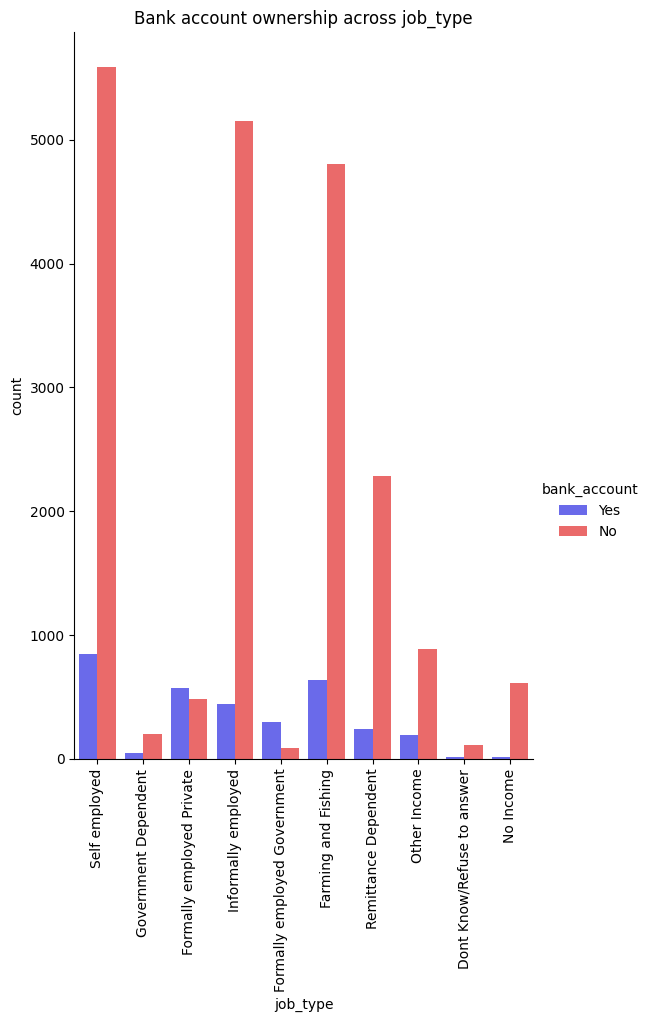

In [31]:
print(train['job_type'].value_counts())
plt.figure(figsize=(10,5))
sns.catplot(x='job_type', hue='bank_account', data=train, kind='count', height=8, aspect=0.7, palette= 'seismic')
plt.title('Bank account ownership across job_type')
plt.xlabel('job_type')
plt.ylabel('count')
plt.xticks(rotation = 90)
plt.show()

- The above plot shows how job_type affect bank account adaption

year
2016    8735
2018    8169
2017    6620
Name: count, dtype: int64


<Figure size 1000x500 with 0 Axes>

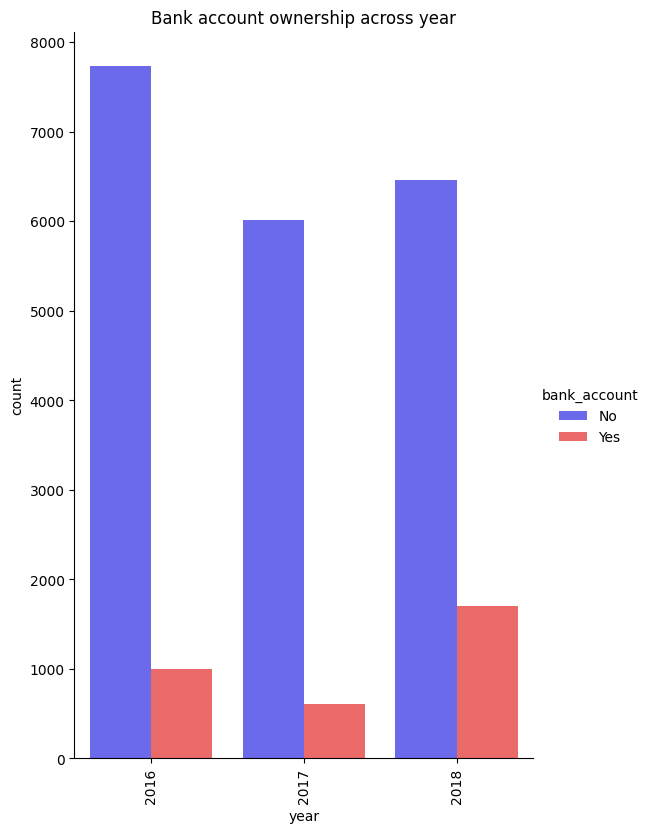

In [32]:
print(train['year'].value_counts())
plt.figure(figsize=(10,5))
sns.catplot(x='year', hue='bank_account', data=train, kind='count', height=8, aspect=0.7, palette= 'seismic')
plt.title('Bank account ownership across year')
plt.xlabel('year')
plt.ylabel('count')
plt.xticks(rotation = 90)
plt.show()

household_size
2     5229
3     3920
4     3474
1     3057
5     2853
6     2096
7     1400
8      751
9      363
10     190
11      69
12      68
13      25
15      11
14      10
16       4
21       1
18       1
17       1
20       1
Name: count, dtype: int64


<Figure size 1000x500 with 0 Axes>

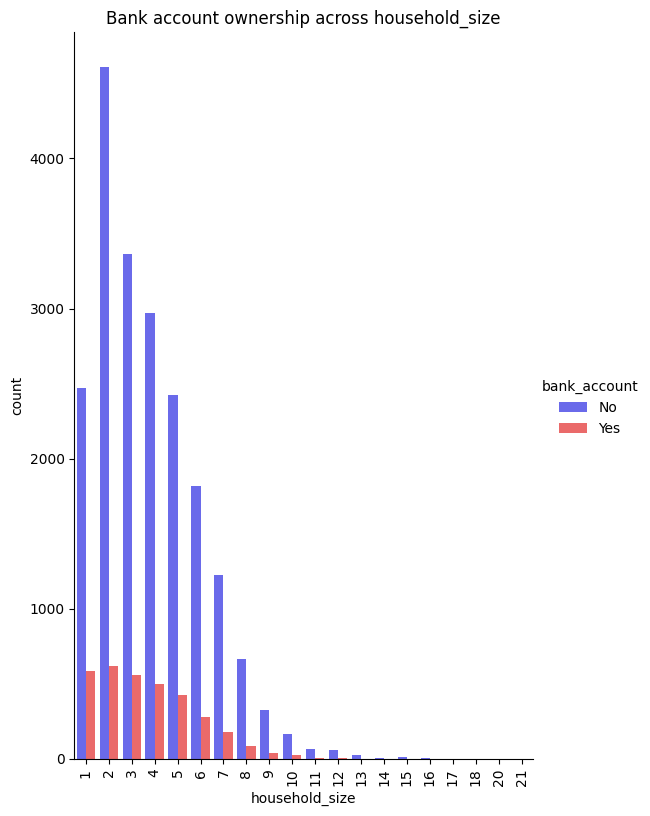

In [33]:
print(train['household_size'].value_counts())
plt.figure(figsize=(10,5))
sns.catplot(x='household_size', hue='bank_account', data=train, kind='count', height=8, aspect=0.7, palette= 'seismic')
plt.title('Bank account ownership across household_size')
plt.xlabel('household_size')
plt.ylabel('count')
plt.xticks(rotation = 90)
plt.show()

In [34]:
DescribeResult = stats.describe(train['age_of_respondent'])
print('Kurtosis: {}\nSkewness: {}\n(for age_of_respondent)'.format(DescribeResult[5], DescribeResult[4]))
print('\nKurtosis > 0 represents taper and Skewness > 0 represents a greater distribution on the right.')

Kurtosis: 0.09986209678376268
Skewness: 0.8416328173885442
(for age_of_respondent)

Kurtosis > 0 represents taper and Skewness > 0 represents a greater distribution on the right.


# Data Processing
- Concatenate both datasets(train,test)

In [35]:
ntrain = train.shape[0]
ntest = test.shape[0]
data = pd.concat((train, test)).reset_index(drop=True)

# Use Label Encoder
 - label encoding for category columns with high value counts

In [36]:
le = LabelEncoder()

le_cols = ['job_type', 'country','relationship_with_head','education_level','marital_status']

for col in le_cols:
    data[col] = le.fit_transform(data[col])

# One Hot Encoding

In [37]:

data = pd.get_dummies(data, columns = ['location_type','year','cellphone_access','gender_of_respondent'])

data.head(5)

,country,uniqueid,bank_account,household_size,age_of_respondent,relationship_with_head,marital_status,education_level,job_type,location_type_Rural,location_type_Urban,year_2016,year_2017,year_2018,cellphone_access_No,cellphone_access_Yes,gender_of_respondent_Female,gender_of_respondent_Male
0,0,uniqueid_1,Yes,3,24,5,2,3,9,True,False,False,False,True,False,True,True,False
1,0,uniqueid_2,No,5,70,1,4,0,4,True,False,False,False,True,True,False,True,False
2,0,uniqueid_3,Yes,5,26,3,3,5,9,False,True,False,False,True,False,True,False,True
3,0,uniqueid_4,No,5,34,1,2,2,3,True,False,False,False,True,False,True,True,False
4,0,uniqueid_5,No,8,26,0,3,2,5,False,True,False,False,True,True,False,False,True


In [38]:
# drop uniquid column
data = data.drop(["uniqueid"], axis=1)


# Separate the Combined Dataset

In [39]:
# Separate train and test data from the combined dataframe
train_df = data[:ntrain]
test_df = data[ntrain:]

In [40]:
# Check the shapes
train_df.shape, test_df.shape

((23524, 17), (10086, 17))

In [42]:
le_col = ['bank_account']

for col in le_col:
   train_df[col] = le.fit_transform(train_df[col])

# Check for Correlation
- Positive Correlation with the target(>0)

In [43]:
train_df.corr()['bank_account'].sort_values()[train_df.corr()['bank_account'].sort_values() > 0]

age_of_respondent            0.019429
location_type_Urban          0.087288
gender_of_respondent_Male    0.117234
year_2018                    0.141673
cellphone_access_Yes         0.209669
education_level              0.323768
bank_account                 1.000000
Name: bank_account, dtype: float64

- Negative Correlation with the target

In [44]:
train_df.corr()['bank_account'].sort_values()[train_df.corr()['bank_account'].sort_values() < 0]

cellphone_access_No           -0.209669
country                       -0.161362
gender_of_respondent_Female   -0.117234
year_2017                     -0.088345
location_type_Rural           -0.087288
relationship_with_head        -0.070853
job_type                      -0.064171
year_2016                     -0.057378
marital_status                -0.038739
household_size                -0.028326
Name: bank_account, dtype: float64

- Visualize the Correlation

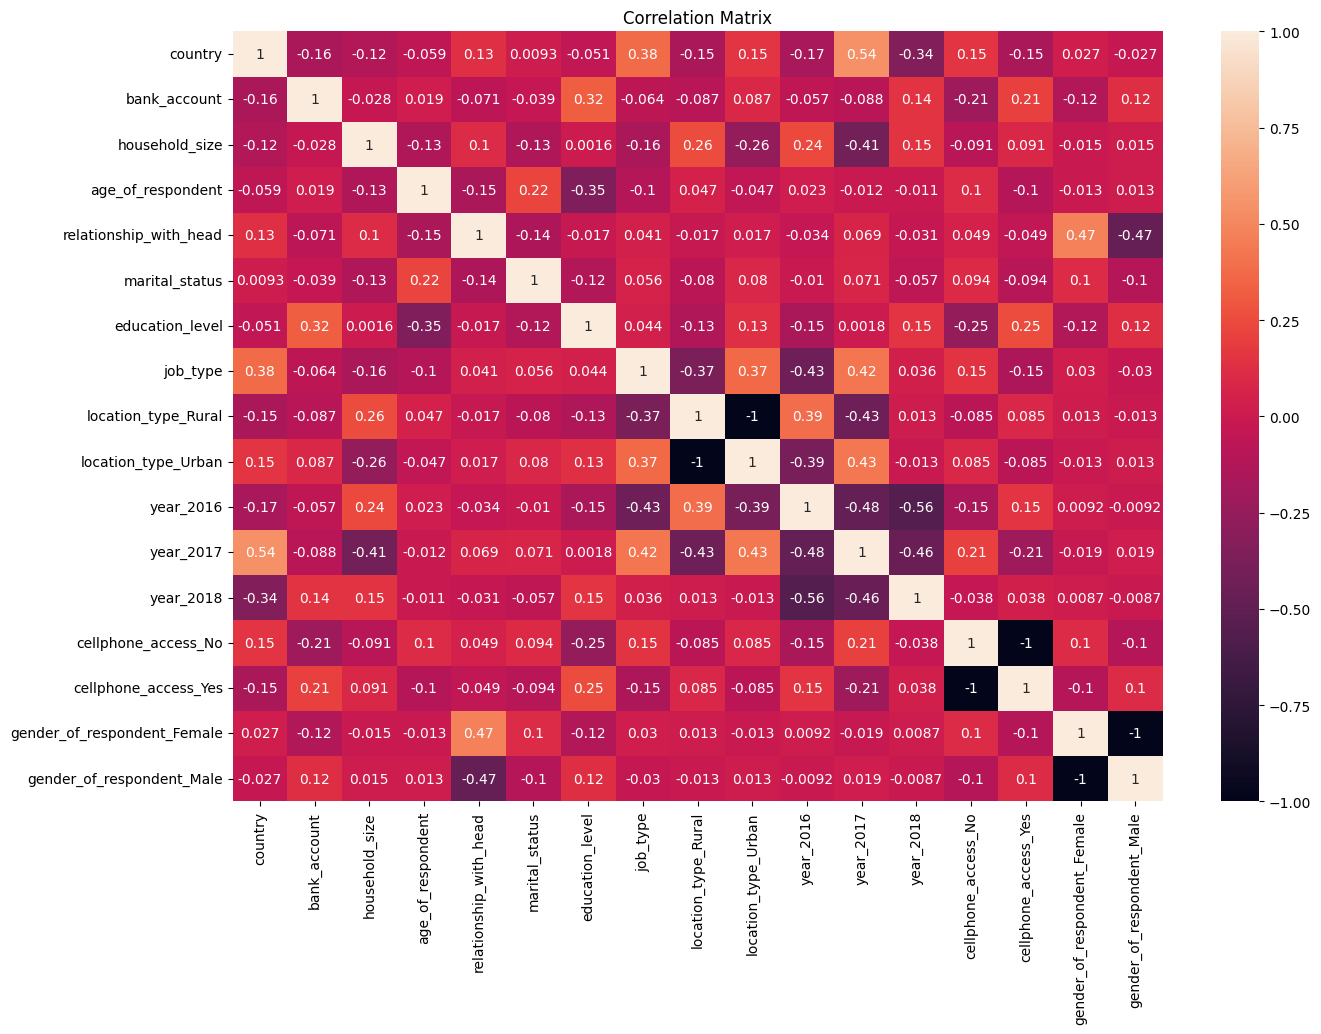

In [46]:
corr_matrix = train_df.corr()
plt.figure(figsize= (15,10))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

# Modelling and Training

In [53]:
main_cols = train_df.columns.difference(['uniqueid','bank_account'])
X = train_df[main_cols]
y = train_df.bank_account
test = test_df[main_cols]
model = CatBoostClassifier(random_state = 42)

train_features, valid_features, train_y, valid_y = train_test_split(X, y, test_size = 0.18, stratify = y,random_state = 47)
model.fit(train_features, train_y,eval_set = [(train_features, train_y),(valid_features,valid_y)], early_stopping_rounds = 500,
          verbose = 200)

Learning rate set to 0.065823
0:	learn: 0.6250117	test: 0.6250787	test1: 0.6255180	best: 0.6255180 (0)	total: 7.21ms	remaining: 7.2s
200:	learn: 0.2586487	test: 0.2586959	test1: 0.2690998	best: 0.2686063 (152)	total: 1.39s	remaining: 5.54s
400:	learn: 0.2416033	test: 0.2416482	test1: 0.2715001	best: 0.2686063 (152)	total: 2.77s	remaining: 4.13s
600:	learn: 0.2292960	test: 0.2293398	test1: 0.2746650	best: 0.2686063 (152)	total: 5.21s	remaining: 3.46s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2686062902
bestIteration = 152

Shrink model to first 153 iterations.


In [54]:
pd.options.display.max_rows = 2200
#define a function to create variable importance dataframe
def get_catt_varimp(model, train_columns, max_vars=350):

    feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
    cv_varimp_df = pd.DataFrame([train_columns, feature_importances_perc]).T

    cv_varimp_df.columns = ['feature_name', 'varimp (%)']

    cv_varimp_df.sort_values(by='varimp (%)', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]

    return cv_varimp_df

get_catt_varimp(model, X.columns)

,feature_name,varimp (%)
4,education_level,15.549509
2,cellphone_access_Yes,11.685885
0,age_of_respondent,11.543806
8,job_type,11.538839
1,cellphone_access_No,10.682936
3,country,10.223913
12,relationship_with_head,4.868503
15,year_2018,4.435177
10,location_type_Urban,4.306615
11,marital_status,3.700451


In [56]:
# extract feature importances
feature_importances = model.feature_importances_
feature_names = train_features.columns

# Sort features and importances in descending order
sorted_idx = feature_importances.argsort()[::-1]
sorted_features = feature_names[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

In [57]:
# Print the top 10 most important features
print("Top 10 most important features:")
for i, (feature, importance) in enumerate(zip(sorted_features[:10], sorted_importances[:10])):
    print(f"{i+1}. {feature}: {importance:.4f}")

Top 10 most important features:
1. education_level: 15.5495
2. cellphone_access_Yes: 11.6859
3. age_of_respondent: 11.5438
4. job_type: 11.5388
5. cellphone_access_No: 10.6829
6. country: 10.2239
7. relationship_with_head: 4.8685
8. year_2018: 4.4352
9. location_type_Urban: 4.3066
10. marital_status: 3.7005


Text(0.5, 1.0, 'CatBoostClassifier features importance (top 50):')

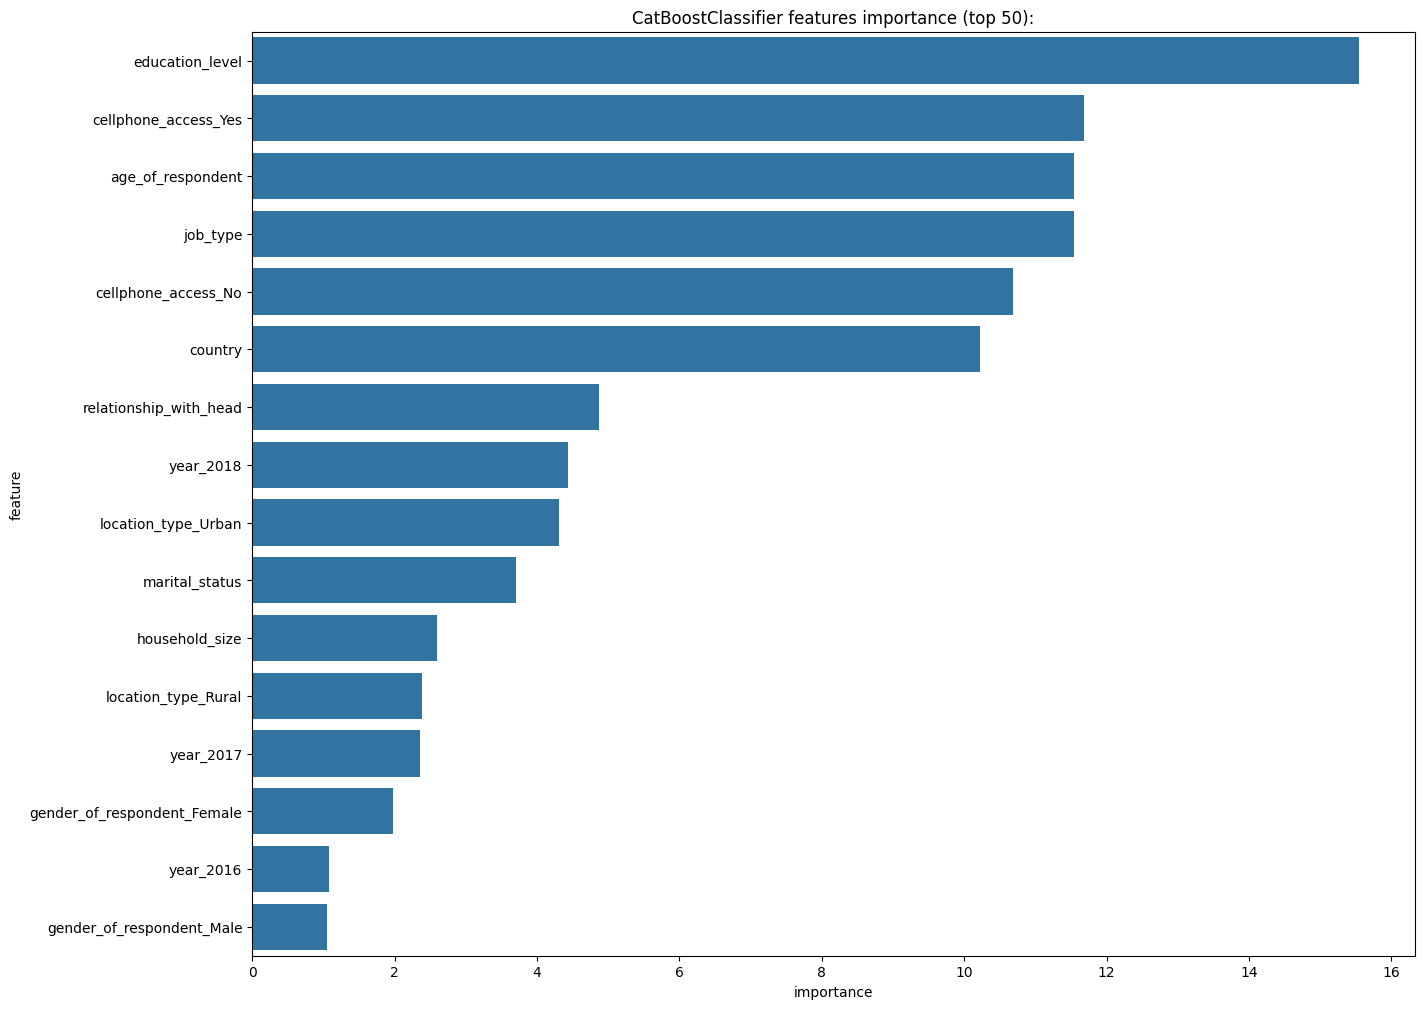

In [62]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(15, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(40))
plt.title('CatBoostClassifier features importance (top 50):')

# Training

In [76]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
params = {
    'iterations': 10000,
    'random_state': 42,
    'bootstrap_type': 'Bernoulli',
    'max_depth': 7,
    'learning_rate': 0.008436034013684798,
    'l2_leaf_reg': 0.8908564261285311,
}

# Initialize StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=10, test_size=0.18, random_state=47)

fold_pred = []
oof_pred = []

i = 1
for train_index, test_index in split.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = CatBoostClassifier(**params)

    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=250, verbose=False)

    preds = model.predict_proba(X_test)
    print(f"Fold {i} log loss: {log_loss(y_test, preds)}")
    oof_pred.append(log_loss(y_test, preds))

    p2 = model.predict_proba(test_scaled)
    fold_pred.append(p2)
    i += 1

print(f"Mean log loss: {np.mean(oof_pred)}")

# Average the predictions from each fold for the test set
fold_pred_mean = np.mean(fold_pred, axis=0)



Fold 1 log loss: 0.26877143568080325
Fold 2 log loss: 0.2805157023277284
Fold 3 log loss: 0.28700042867406667
Fold 4 log loss: 0.2773197671245052
Fold 5 log loss: 0.27217979945729737
Fold 6 log loss: 0.27853497720044484
Fold 7 log loss: 0.2768435042686817
Fold 8 log loss: 0.2889394164541704
Fold 9 log loss: 0.2789677216530548
Fold 10 log loss: 0.2796035965271851
Mean log loss: 0.2788676349367938


In [ ]:
# Create the submission DataFrame
submission = pd.DataFrame({"uniqueid": uniqueid + " x " + country,
                           "bank_account": np.zeros(len(uniqueid))})
submission['bank_account'] = fold_pred_mean[:, 1]

# Save the submission file
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")